In [2]:
import numpy as np
import pandas as pd
import sys, os
import random
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import MDS,TSNE
from umap import UMAP
from sklearn.cluster import KMeans
import re
from plotnine import *

seed = 20210118
np.random.seed(seed)
random.seed(seed)


In [23]:
# load data
use_data_site = pd.read_csv("data/site_scores_BA1_specific.csv")
use_data_mut = pd.read_csv("data/mut_scores_BA1_specific.csv")
filter_out_abs = []

BA1_specific = np.unique(use_data_site['antibody'])

site_mat = use_data_site.groupby(['antibody','site']).mean().reset_index().pivot(index='antibody', columns='site', values='site_total_escape').fillna(0)

use_res = (use_data_mut
           .pivot(index=['antibody','condition', 'site'], columns='mutation', values='mut_escape')
           .fillna(0)
           .melt(var_name='mutation', value_name='mut_escape', ignore_index=False)
           .reset_index()
           .groupby(['antibody','site', 'mutation'])
           .mean()
           .reset_index())


from sklearn.preprocessing import normalize,StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import cosine_similarity
from plotnine import *

block_sites = [361] # C361 is everywhere

# integrate with 1538 WT profiles

ref_groups = pd.read_csv("outputs/antibody_clusters.csv")

ref_sites = np.load("outputs/site_mat_sites_WT.npy")
ref_site_mat = pd.DataFrame(np.load("outputs/site_mat_WT.npy"), columns=ref_sites, index=ref_groups['antibody'])

use_sites = np.setdiff1d(np.intersect1d(ref_sites, site_mat.columns), block_sites)

site_mat.index = site_mat.index+'_BA1'
ref_site_mat.index = ref_site_mat.index+'_WT'

_ = [x+'_BA1' for x in BA1_specific]
site_mat_all = pd.concat([site_mat.query('antibody in @_')[use_sites], ref_site_mat[use_sites]])

site_mat_norm = normalize(VarianceThreshold(0.1).fit_transform(site_mat_all), axis=0, norm='l2')
dis_mat = 1.0 - np.corrcoef(site_mat_norm)

print(site_mat_all.shape)
print(site_mat_norm.shape)
Ab_list = site_mat.query('antibody in @_').index

(1640, 172)
(1640, 92)


In [33]:
from sklearn.manifold import MDS,TSNE
from sklearn.cluster import KMeans
from umap import UMAP

def get_tsne(dis_mat, AbNames, seed=20220408, mds_comp=20, perplexity=35, NCLUST = 10, method = 'TSNE'):
    mds_high_res = MDS(n_components=mds_comp, dissimilarity="precomputed", random_state=seed, n_jobs=-1).fit_transform(dis_mat)
    
    np.save(file="outputs/mds_res_"+str(mds_comp)+'_tmp_BA1.npy', arr=mds_high_res) 
    if method == 'TSNE':
        tsne_res = TSNE(random_state=seed, perplexity=perplexity, n_jobs=-1).fit_transform(mds_high_res)
    elif method == 'UMAP':
        tsne_res = UMAP(random_state=seed, n_neighbors=perplexity, n_jobs=-1).fit_transform(mds_high_res)
    
    clust = KMeans(n_clusters=NCLUST, random_state=seed).fit(mds_high_res).labels_
    clust_rename = [str(i) for i in range(NCLUST)]
    
    anchors = {
        'BD45-54_WT': 'A',
        'BD45-3_WT': 'B',
        'BD30-593_WT': 'C',
        'BD45-13_WT': 'D1',
        'BD45-4_WT': 'D2',
        'BD55-5840_WT': 'E1',
        'BD45-147_WT': 'E2.2',
        'BD55-114_WT': 'E2.1',
        'BD45-105_WT': 'E3',
        'BD55-5239_WT': 'F2',
        'BD55-3372_WT': 'F3',
        'BD45-14_WT': 'F1',
    }
    _ab_clust = pd.Series(clust)
    _ab_clust.index = AbNames
    for _a in list(anchors.keys()):
        _group = anchors[_a]
        _cl = int(_ab_clust[_a])
        clust_rename[_cl] = _group
    clust = np.array(clust_rename)[clust]
    dimRed_res_df = pd.DataFrame(tsne_res).assign(group=clust)
    dimRed_res_df.index = AbNames
    dimRed_res_df.columns = ["TSNE1", "TSNE2", "group"]

    dimRed_res_df = dimRed_res_df.query('antibody not in @filter_out_abs')
    return dimRed_res_df

def get_tsne_2(mds_high_res, AbNames, seed=20220408, perplexity=35, NCLUST = 4):
    tsne_res = TSNE(random_state=seed, perplexity=perplexity, n_jobs=-1).fit_transform(mds_high_res)
    # tsne_res = UMAP(random_state=seed, n_neighbors=perplexity, n_jobs=-1).fit_transform(mds_high_res)
    
    clust = KMeans(n_clusters=NCLUST, random_state=seed).fit(mds_high_res).labels_
    clust_rename = [str(i) for i in range(NCLUST)]
    
    anchors = {
        'OC220225-SN0281_BA1': 'D_Omi',
        'OC220225-SN0313_BA1': 'A_Omi',
        'OC220302-SN0785_BA1': 'B_Omi',
        'OC220302-SN0799_BA1': 'F3_Omi',
    }
    _ab_clust = pd.Series(clust)
    _ab_clust.index = AbNames
    for _a in list(anchors.keys()):
        _group = anchors[_a]
        _cl = int(_ab_clust[_a])
        clust_rename[_cl] = _group
    clust = np.array(clust_rename)[clust]
    _df = pd.DataFrame(tsne_res).assign(group=clust.astype(str))
    _df.index = AbNames
    _df.index.name = 'antibody'
    _df.columns = ["TSNE1", "TSNE2", "group"]

    _df = _df.query('antibody not in @filter_out_abs')
    return _df


In [34]:
import re

seed = 53431523
dimRed_res_df = get_tsne(dis_mat, site_mat_all.index, seed=seed,NCLUST=12, method='TSNE')

dimRed_res_df = dimRed_res_df.assign(base=[x.split('_')[-1] for x in dimRed_res_df.index])
dimRed_res_df.index = ['_'.join(x.split('_')[0:-1]) for x in dimRed_res_df.index]

bd45_names = pd.read_csv("data/BD45_names.csv", index_col=0)['name'].to_dict()
Ab_rename = {
    'BD45-54':"LY-CoV016", 'BD30-593':"DXP-593", 'BD30-604':'DXP-604', 
    'BD45-21':'BRII-196', 'S2K146_Bloom':"S2K146",'CR3022_Bloom':'CR3022',# "S2X259_Bloom": "S2X259",
}

def parse_ab_show_name(name):
    if name in Ab_rename:
        return Ab_rename[name]
    if re.match(pattern='^BD30', string=name):
        return name[0:2]+name[4:]
    if re.match(pattern='^BD45', string=name):
        return bd45_names[name]
    if re.match(pattern='^BD55', string=name):
        _num = int(name.split('-')[1])
        if (_num < 300):
            return 'BD-'+str(_num+630)
        else:
            return name
    if re.match(pattern='^OC', string=name):
        _num = name.split('-')[1]
        if (_num[0:2] == "GC"):
            return 'BD57-'+str(int(_num[2:]))
        elif (_num[0:2] == "SN"):
            return 'BD56-'+str(int(_num[2:]))
        else:
            print("rename error. not GC/SN")
            raise ValueError
    else:
        return name

dimRed_res_df = (
    dimRed_res_df.assign(show_name = [parse_ab_show_name(x) for x in dimRed_res_df.index])
                 .merge(ref_groups.reset_index(drop=True)[['antibody', 'group']], how='left', left_index=True, right_on='antibody')
                 .set_index('antibody')
)
print(len(dimRed_res_df.dropna().query('group_x != group_y')))
dimRed_res_df.group_y.fillna(dimRed_res_df['group_x'], inplace=True)
dimRed_res_df['TSNE1'] = -dimRed_res_df['TSNE1']
dimRed_res_df['TSNE2'] = -dimRed_res_df['TSNE2']

49


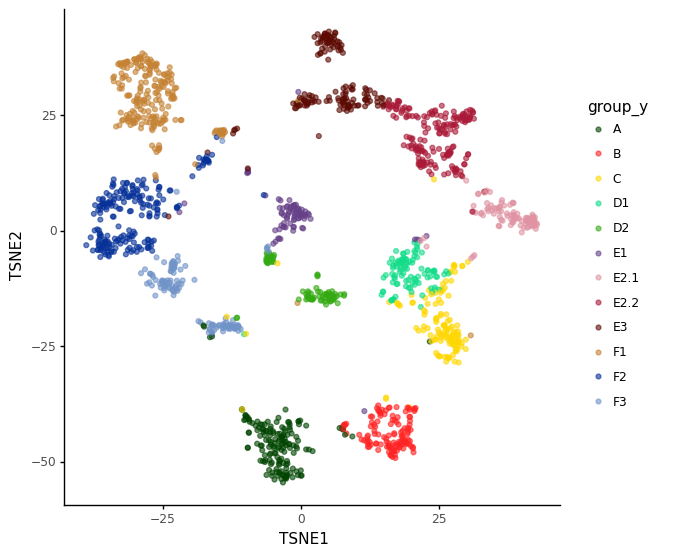

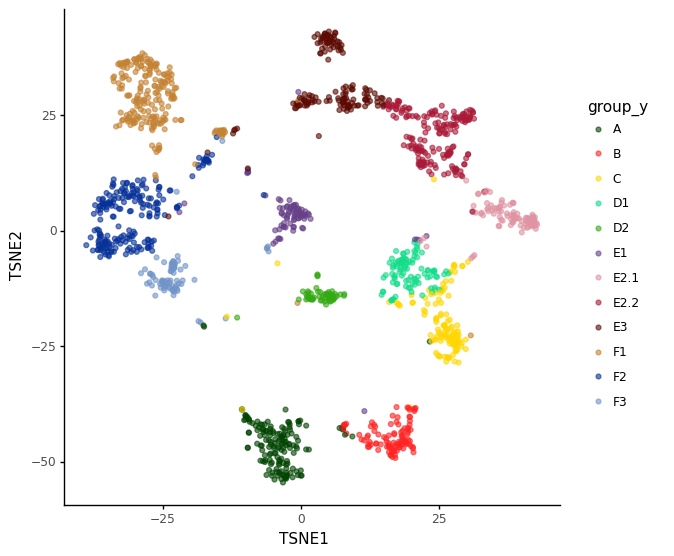

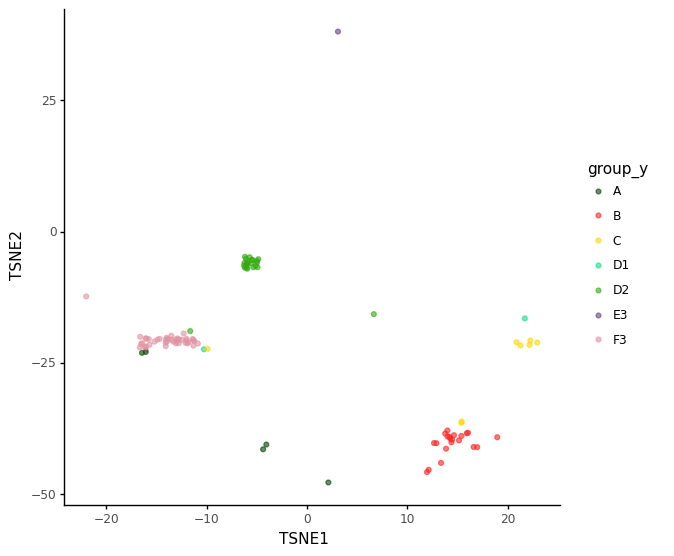

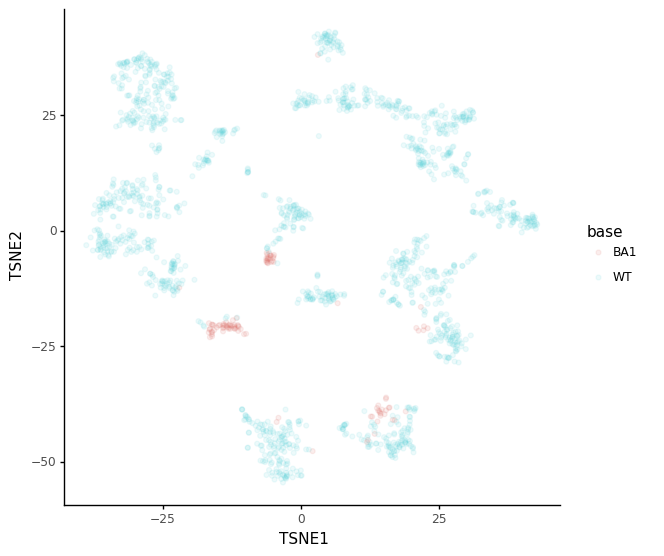

In [35]:
colors = ["#004400","#ff2323","#ffd700","#11dd89",'#33aa11', "#664088", "#e094a3",'#aa1937', "#5c0a02", "#c58233","#063199", "#7093c8"]

print(
ggplot(dimRed_res_df.reset_index(), aes(x='TSNE1', y='TSNE2'))+geom_point(aes(color='group_y'), alpha=0.6)+theme_classic()+theme(aspect_ratio=1.0)+scale_color_manual(values=colors),
ggplot(dimRed_res_df.reset_index().query('base == "WT"'), aes(x='TSNE1', y='TSNE2'))+geom_point(aes(color='group_y'), alpha=0.6)+theme_classic()+theme(aspect_ratio=1.0)+scale_color_manual(values=colors),
ggplot(dimRed_res_df.reset_index().query('base == "BA1"'), aes(x='TSNE1', y='TSNE2'))+geom_point(aes(color='group_y'), alpha=0.6)+theme_classic()+theme(aspect_ratio=1.0)+scale_color_manual(values=colors),
ggplot(dimRed_res_df.reset_index(), aes(x='TSNE1', y='TSNE2'))+geom_point(aes(color='base'), alpha=0.1)+theme_classic()+theme(aspect_ratio=1.0)
)

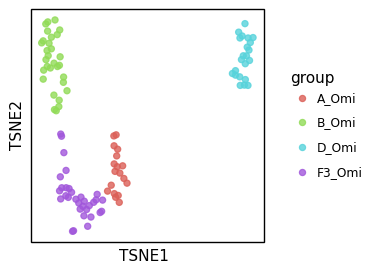

In [36]:
BA1_alone_tsne = get_tsne_2(np.load('outputs/mds_res_20_tmp_BA1.npy')[0:len(Ab_list),:], 
                            Ab_list, perplexity=10, seed=114514).assign(antibody = lambda x: [y.split('_')[0] for y in x.index]).set_index('antibody')
p = (
    ggplot(BA1_alone_tsne, aes(x='TSNE1',y='TSNE2'))+
        geom_point(aes(color='group'),size=2,alpha=0.8)+
        theme_classic()+
        theme(aspect_ratio=1.0,
              figure_size=(3,3),
              axis_text=element_blank(), 
              axis_line=element_blank(), 
              axis_ticks=element_blank(),
              panel_border = element_rect(colour = "black", size=1))
)
print(p)

BA1_alone_tsne.assign(
    show_name = [parse_ab_show_name(x) for x in BA1_alone_tsne.index]
).to_csv('outputs/antibody_clusters_BA1_specific.csv')


In [31]:
use_res_min = use_res.query('antibody in @BA1_alone_tsne.index')
use_res_min = use_res_min.assign(group=[BA1_alone_tsne.loc[x, 'group'] for x in use_res_min['antibody']])[['antibody','site','mutation','mut_escape','group']]
use_res_min.to_csv("outputs/use_abs_res_BA1_specific.csv", index=None)
group_ab_num = BA1_alone_tsne.groupby(['group']).count().iloc[:,0].to_dict()
_ = use_res_min.groupby(['site', 'group', 'mutation']).sum().reset_index()
_ = _.assign(group_ab_num = [group_ab_num[x] for x in _['group']])
_['mut_escape'] = _['mut_escape'] / _['group_ab_num']

use_res_min.groupby(['antibody', 'site', 'group']).sum().reset_index().groupby(['group', 'site']).mean().reset_index().to_csv('outputs/group_site_mean_BA1_specific.csv', index=None)

_.query("mut_escape > 0.03")[['site','group','mutation','mut_escape']].to_csv("outputs/group_mut_mean_BA1_specific.csv", index=None)

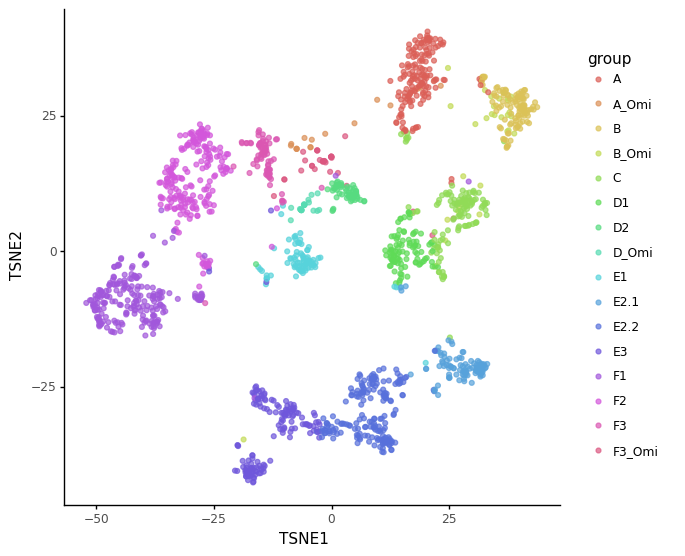

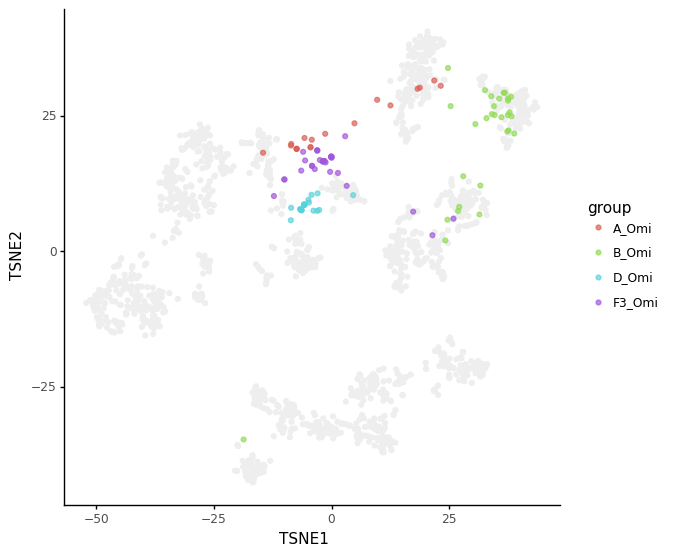

In [37]:
# for projection of the BA.1 specific points onto the WT tsne map

from sklearn.metrics.pairwise import euclidean_distances
mds_res = np.load("outputs/mds_res_20_tmp_BA1.npy")
ref_mds = np.load("outputs/mds_res_20.npy")

ref_groups = pd.read_csv("outputs/antibody_clusters.csv")

dist = pd.DataFrame(euclidean_distances(mds_res), 
             index=dimRed_res_df.index+'_'+dimRed_res_df['base'], 
             columns=dimRed_res_df.index+'_'+dimRed_res_df['base']).melt(ignore_index=False)
dist.index.name = 'Ab1'
dist.columns = ['antibody', 'value']

x = [i + '_BA1' for i in BA1_specific]
y = ref_groups['antibody'] + '_WT'

dist = dist.query('Ab1 in @x and antibody in @y')

ref_groups.index = ref_groups['antibody']+'_WT'

KNNs = {}
embed = np.empty((len(Ab_list), mds_res.shape[1]), dtype=float)
embed_2 = []
ref_groups['number'] = range(len(ref_groups))
for i in range(len(Ab_list)):
    ab = Ab_list[i]
    _nns = ref_groups.loc[dist.loc[ab,:].sort_values('value').head(10)['antibody'],['group', 'TSNE1', 'TSNE2', 'number']]
    KNNs[ab] = [(_nns.index[i].split('_')[0], _nns['group'][i]) for i in range(len(_nns))]
    _id = _nns['number'].to_numpy()
    assert(len(np.setdiff1d(ref_groups.index[_id], _nns.index)) == 0)
    embed[i,:] = ref_mds[_id, :].mean(axis=0)
    embed_2.append(pd.DataFrame(_nns[['TSNE1','TSNE2']].mean()).transpose().assign(antibody=[ab]).set_index('antibody'))
embed_2 = pd.concat(embed_2)

all_embed = np.concatenate([ref_mds, embed])
integrated_dimRed = pd.concat([
    embed_2.assign(antibody=[x.split('_')[0] for x in embed_2.index]).assign(show_name = lambda x:x['antibody'], 
                                                                             base='BA1', 
                                                                             group=lambda x: BA1_alone_tsne.loc[x['antibody'], 'group'].to_list()),
    ref_groups.drop(columns='number').assign(base='WT')])

print(
    ggplot(integrated_dimRed, aes(x='TSNE1', y='TSNE2'))+geom_point(aes(color='group'), alpha=0.7)+theme_classic()+theme(aspect_ratio=1.0),
    (
        ggplot(integrated_dimRed.query('base == "WT"'), aes(x='TSNE1', y='TSNE2'))+
            geom_point(color = '#eeeeee')+
            geom_point(integrated_dimRed.query('base == "BA1"'), aes(color='group'), alpha=0.7)+
            theme_classic()+theme(aspect_ratio=1.0)
    )
)

In [ ]:
import logomaker
from matplotlib import rcParams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
rcParams['pdf.fonttype'] = 42

def plot_res_logo(res, prefix, shownames={}, rownames=None, site_thres=0.1, force_plot_sites = None, force_ylim = None, width=None):
    flat_res = res.pivot(index=['antibody', 'site'], columns='mutation', values='mut_escape').fillna(0)
    sites_mean_score = flat_res.mean(axis=1)
    sites_total_score = flat_res.sum(axis=1)
    _ = sites_total_score[sites_total_score>site_thres].index
    strong_sites = np.unique(np.array(sorted([i[1] for i in _])))
    print(strong_sites)
    

    # struc_interface = [403,405,408,409,415,416,417,420,421,453,455,456,457,458,459,460,473,474,475,476,477,486,487,489,490,493,494,500,501,502,505]
    struc_interface = [339, 371, 373, 375, 417, 440, 446, 477, 478, 484, 493, 496, 498, 501, 505] # Omicron mut (not including 346)
    blue_sites = [376, 405, 408]
    plot_sites = np.union1d(strong_sites, struc_interface+blue_sites)
    # plot_sites = strong_sites
    plot_sites = plot_sites[plot_sites < 520].astype(int)
    print(plot_sites)
    
    if force_plot_sites is not None:
        plot_sites = force_plot_sites
    
    flat_res = flat_res[flat_res.index.isin(plot_sites, level=1)]

    _ = pd.DataFrame(sites_total_score)
    _.columns = ['value']
    _['site'] = [i[1] for i in _.index]
    _['antibody'] = [i[0] for i in _.index]

    if rownames is not None:
        Abs = rownames
    else:
        Abs = np.unique([i[0] for i in flat_res.index])
    print(Abs)
    Npages = len(Abs)//10 + 1
    if width is None:
        width=26
    with PdfPages(prefix+'_aa_logo.pdf') as pdf:
        for p in range(Npages):
            Abs_p = Abs[p*10:min(len(Abs),(p+1)*10)]
            fig = plt.figure(figsize=(width,len(Abs_p)*4.6)).subplots_adjust(wspace=0.2,hspace=0.5)
            site2pos = {}
            for i in range(len(plot_sites)):
                site2pos[plot_sites[i]] = i

            for i in range(len(Abs_p)):
                ab = Abs_p[i]
                _ = flat_res.query('antibody == @ab').droplevel(0)
                add_sites = np.setdiff1d(plot_sites, _.index)
                for _site in add_sites:
                    _.loc[_site,:] = 0.0
                _ = _.sort_index()
                _.index = range(len(_))
                ax = plt.subplot(len(Abs_p), 1, i+1)
                logo = logomaker.Logo(_,
                               ax=ax, 
                               color_scheme='dmslogo_funcgroup', 
                               vpad=.1, 
                               width=.8)
                logo.style_xticks(anchor=0, spacing=1, rotation=90, fontsize=16)
                _max = np.sum(_.to_numpy(), axis=1).max()
                ax.yaxis.set_tick_params(labelsize=20)
                if force_ylim is not None:
                    ax.set_ylim(0, force_ylim)
                elif _max < 3:
                    ax.set_ylim(0,3)
                    ax.set_yticks(range(0, 3, 1))
                elif _max < 5:
                    ax.set_yticks(range(0, int(_max)+1, 1))
                elif _max < 8:
                    ax.set_yticks(range(0, int(_max)+1, 2))
                else:
                    ax.set_yticks(range(0, int(_max)+1, 3))

                for ifsite in struc_interface:
                    if ifsite in plot_sites:
                        logo.highlight_position(p=site2pos[ifsite], color='gold', alpha=.2)
                if 346 in plot_sites:
                    logo.highlight_position(p=site2pos[346], color='red', alpha=.1)
                for ifsite in blue_sites:
                    if ifsite in plot_sites:
                        logo.highlight_position(p=site2pos[ifsite], color='blue', alpha=.1)

                ax.set_xticklabels(plot_sites)

                if ab in shownames:
                    ax.set_title(shownames[ab], fontsize=20, fontweight="bold")
                else:
                    ax.set_title(ab, fontsize=20, fontweight="bold")
            pdf.savefig()
            plt.close()

In [ ]:
# Abs denoising

test_abs = np.unique(use_res['antibody'])
print(test_abs, len(test_abs))
use_res_clean = use_res.query('antibody in @test_abs')
use_site = use_res_clean.groupby(['antibody', 'site']).sum()
use_site_median = use_site.query('mut_escape > 0').reset_index().groupby(['antibody']).median()['mut_escape'].to_dict()
use_mut_median = use_res_clean.query('mut_escape > 0').groupby(['antibody']).median()['mut_escape'].to_dict()

use_site = use_site['mut_escape'].to_dict()

use_res_clean = use_res_clean.assign(site_total = [use_site[(use_res_clean.loc[x,]['antibody'],use_res_clean.loc[x,]['site'])] for x in use_res_clean.index],
                                     site_median = [use_site_median[use_res_clean.loc[x,]['antibody']] for x in use_res_clean.index],
                                     mut_median = [use_mut_median[use_res_clean.loc[x,]['antibody']] for x in use_res_clean.index]
                                     group = [BA1_alone_tsne.loc[x, 'group'] for x in use_res_clean['antibody']]).query('site_total > 2*site_median and mut_escape > 2*mut_median')

use_res_clean = (
    use_res_clean[['antibody', 'site', 'mutation', 'mut_escape', 'group']]
        .assign(show_name = [parse_ab_show_name(x) for x in use_res_clean['antibody']])
)

use_res_clean.to_csv('outputs/results_clean_BA1_specific.csv', index=None)
plot_res_logo(use_res_clean, 'pdf/BA1_specific_all', site_thres=0.1)